In [23]:
from airbnb_analysis_service import AirbnbAnalysisService
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

if __name__ == "__main__":

    # create service class
    airbnbAnalysis = AirbnbAnalysisService()

    # get all tables in form of a list
    listings = airbnbAnalysis.get_listings()

    print(f"listings {listings[0]}")

    # Schritt 1: Umwandeln in DataFrames
    listings_df = pd.DataFrame([l.__dict__ for l in listings])

listings Listing(id=178448, listing_url='https://www.airbnb.com/rooms/178448', scrape_id=20241230011608, last_scraped='2024-12-30', source='city scrape', name='a lovely place, top location', description='Very central location, 5 min walk from Bahnhof Enge, 10min walk from the lake.<br />quiet, <br />big rooms of 20m2,', neighborhood_overview='We live in one of the top locations of Zürich, the Hürrlimann Areal where the headquarter of Google Europe is located <br />Its a 5 Minutes walk to Bahnhof Enge, 10 Minutes walk to the Bahnhofstrasse, 10 minutes to the lakeside.', picture_url='https://a0.muscache.com/pictures/7d41e016-e818-4fe1-9d42-a5d0ae34bdda.jpg', host_id=854016, host_url='https://www.airbnb.com/users/show/854016', host_name='Delphine', host_since='2011-07-22', host_location='Zurich, Switzerland', host_about='I am a quiet, friendly and caring person\r\nI love Creativity, Painting, Writing, Reading, Music, Dancing, Yoga, Fashion and Decoration\r\nI travel since ever and mostly 

## Objective 3 – Performance Optimierung & Benchmarking

Ziel dieses Untersuchungsabschnitts ist es, die zentralen Erfolgsfaktoren für den Superhost-Status auf Airbnb datenbasiert zu identifizieren. Im Fokus steht die Frage, welche quantifizierbaren Merkmale Top-Performer (Superhosts) von anderen Gastgebern im Raum Zürich unterscheiden – und wie die InvestZurich AG diese Erkenntnisse gezielt zur Optimierung ihrer eigenen Objekte nutzen kann.

Der Superhost-Status ist ein Qualitätssiegel innerhalb des Airbnb-Ökosystems, das mit höherer Sichtbarkeit, gesteigerter Buchungswahrscheinlichkeit und verbessertem Gästevertrauen einhergeht. Für professionelle Anbieter wie die InvestZurich AG stellt dieser Status daher einen strategisch bedeutsamen Wettbewerbsvorteil dar.

In einem ersten Schritt wird untersucht, welche Eigenschaften (z.B. Antwortzeit, Buchungsannahmequote, Bewertungsniveau oder Gastgeberaktivität) statistisch signifikant mit dem Superhost-Status korrelieren. Anschliessend werden mittels Klassifikationsmodellen – wie etwa Entscheidbäumen oder Random Forests – die einflussreichsten Prädiktoren herausgearbeitet.

Das Ziel besteht darin, auf Grundlage dieser Daten konkrete Handlungspfade für die InvestZurich AG abzuleiten, etwa zur Verbesserung von Gastgebermetriken oder zur internen Qualitätssicherung. Der Fokus liegt dabei nicht nur auf reiner Leistungsdiagnostik, sondern auf einer operationalisierbaren Optimierungsstrategie.
?

Die nachfolgende Analyse visualisiert zentrale Merkmale, die signifikant mit dem Superhost-Status zusammenhängen – und bildet damit die Grundlage für gezielte Massnahmen zur Performance-Steigerung.


### Datenaufbereitung

Im Rahmen der Datenaufbereitung wurden zunächst 22 relevante Merkmale ausgewählt, die potenziell Einfluss auf den Superhost-Status haben. Dazu zählen hostbezogene Informationen (z. B. Antwortzeit, Annahmequote, Verifizierung), Objektmerkmale (wie Zimmeranzahl, Preis, Mindestaufenthalt) sowie Bewertungskennzahlen und Aktivitätsindikatoren (z. B. Anzahl Bewertungen pro Monat, durchschnittliche Bewertung).

Prozentangaben wie die Antwort- und Annahmequote wurden in dezimale Werte umgewandelt, um sie numerisch auswerten zu können. Anschliessend wurden alle Datensätze mit fehlendem Superhost-Status entfernt, um eine saubere Klassifikationsbasis zu schaffen. Der Zielwert wurde anschliessend in eine binäre Variable überführt (1 = Superhost, 0 = Nicht-Superhost).

Fehlende numerische Werte wurden mit dem Median der jeweiligen Spalte ersetzt, um Ausreisserverzerrungen zu vermeiden. Schliesslich wurden ausgewählte kategoriale Merkmale, darunter etwa die Zimmerart oder Buchbarkeit, mittels Label Encoding in numerische Kategorien umgewandelt, sodass sie für maschinelles Lernen geeignet sind.

In [24]:
cols = [
    'host_is_superhost', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate_percent', 'host_total_listings_count', 'host_has_profile_pic',
    'host_identity_verified', 'room_type', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'price', 'minimum_nights', 'number_of_reviews',
    'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
    'review_scores_value', 'instant_bookable', 'availability_365', 'reviews_per_month'
]
listings_df = listings_df[cols].copy()
def convert_percent(x):
    try:
        if isinstance(x, str) and '%' in x:
            return float(x.strip('%')) / 100
        return float(x) / 100
    except:
        return np.nan

listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(convert_percent)

listings_df['host_acceptance_rate_percent'] = listings_df['host_acceptance_rate_percent'].apply(convert_percent)

listings_df = listings_df[listings_df['host_is_superhost'].notna()]

listings_df['host_is_superhost'] = listings_df['host_is_superhost'].astype(str).str.lower().map({'true': 1, 'false': 0, 't': 1, 'f': 0})

listings_df.fillna(listings_df.median(numeric_only=True), inplace=True)

for col in ['host_response_time', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'room_type']:
    listings_df[col] = LabelEncoder().fit_transform(listings_df[col].astype(str))

### Überblick über die Verteilung des Superhost-Status

Zur ersten quantitativen Einschätzung wurde analysiert, wie viele Anbieter im Datensatz den Superhost-Status tragen und wie hoch deren Anteil im Vergleich zu regulären Hosts ist. Dazu wurden sowohl die absoluten Häufigkeiten als auch die prozentuale Verteilung berechnet.

Anschliessend wurde die Verteilung visuell mittels Balkendiagramm dargestellt. Die zweiseitige Darstellung zeigt deutlich, wie stark (oder schwach) Superhosts im Verhältnis zur Gesamtmenge vertreten sind. Diese Basisanalyse ist wichtig, um potenzielle Klassenungleichgewichte zu erkennen, die bei der späteren Modellierung berücksichtigt werden müssen.

Anzahl Superhosts vs. Nicht-Superhosts:
host_is_superhost
0    1256
1     656
Name: count, dtype: int64

Prozentuale Verteilung:
host_is_superhost
0    65.690377
1    34.309623
Name: proportion, dtype: float64


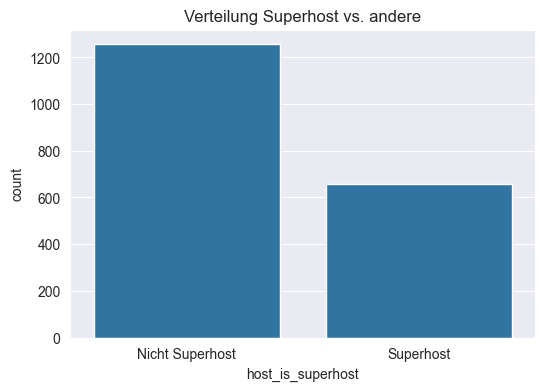

In [25]:
print("Anzahl Superhosts vs. Nicht-Superhosts:")
print(listings_df['host_is_superhost'].value_counts())
print("\nProzentuale Verteilung:")
print(listings_df['host_is_superhost'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6,4))
sns.countplot(x='host_is_superhost', data=listings_df)
plt.title("Verteilung Superhost vs. andere")
plt.xticks([0,1], ['Nicht Superhost', 'Superhost'])
plt.show()

Im betrachteten Datensatz sind rund 34 % der Anbieter Superhosts, während etwa 66 % keine Superhosts sind. Dies zeigt, dass der Superhost-Status zwar kein Standard, aber auch nicht selten ist – es handelt sich um eine bedeutende Teilgruppe.

Diese Verteilung weist auf eine gewisse Klassenungleichheit hin, was bei der Modellierung beachtet werden sollte (z. B. durch Balancing-Strategien). Gleichzeitig zeigt die relativ hohe Quote von Superhosts, dass der Status erreichbar ist – sofern bestimmte Merkmale oder Verhaltensweisen erfüllt werden.

Für InvestZurich AG bedeutet das: Der Superhost-Status stellt ein realistisches Ziel dar, das auf Grundlage datenbasierter Erkenntnisse gezielt angestrebt werden kann.

### Merkmalsvergleich zwischen Superhosts und Nicht-Superhosts

In diesem Abschnitt wird untersucht, wie sich die numerischen Merkmale zwischen Superhosts und Nicht-Superhosts unterscheiden. Dazu werden zunächst die Mittelwerte aller numerischen Variablen separat für beide Gruppen berechnet und gegenübergestellt.

Anschliessend wird für jedes Merkmal die prozentuale Differenz berechnet – also wie stark sich der Mittelwert bei Superhosts im Vergleich zu Nicht-Superhosts unterscheidet. Diese Analyse zeigt, welche Faktoren bei Superhosts überdurchschnittlich stark ausgeprägt sind und somit potenziell entscheidende Erfolgsfaktoren darstellen.

Die 15 Merkmale mit dem grössten relativen Unterschied werden in einem Balkendiagramm visualisiert. Dadurch wird sichtbar, welche quantitativen Eigenschaften besonders stark mit dem Superhost-Status assoziiert sind – z. B. häufige Bewertungen, hohe Sauberkeit oder hohe Buchungsaktivität. Diese Erkenntnisse bilden eine fundierte Grundlage für die Ableitung konkreter Optimierungsmassnahmen.


Mittelwerte der Merkmale nach Superhost-Status:
host_is_superhost                      0           1
availability_365              169.201433  181.342988
price                         176.003981  177.123476
number_of_reviews              29.958599   62.516768
host_total_listings_count      36.052548   50.344512
review_scores_communication     4.755732    4.904177
review_scores_cleanliness       4.632635    4.858628
review_scores_rating            4.630701    4.821738
review_scores_value             4.506377    4.681372
host_response_time              2.881369    3.687500
minimum_nights                  5.736465    3.393293
accommodates                    2.888535    2.981707
reviews_per_month               1.304817    1.771631
beds                            1.551752    1.704268
bedrooms                        1.226911    1.175305
bathrooms                       1.125398    1.128049
host_response_rate              0.919092    0.993049
host_has_profile_pic            0.968949    0.9923

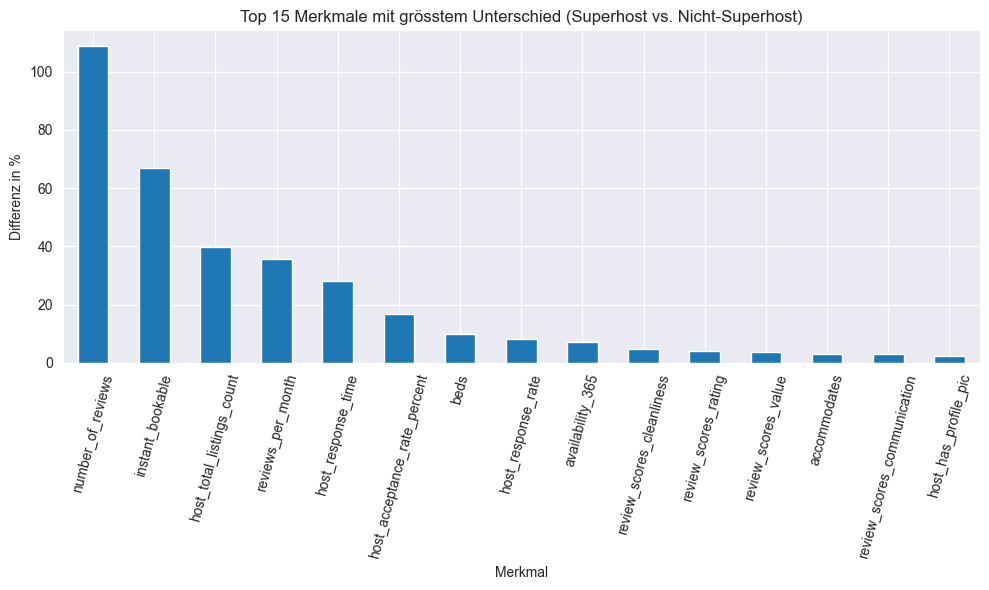

In [26]:
grouped_stats = listings_df.groupby('host_is_superhost').mean(numeric_only=True).T
print("\nMittelwerte der Merkmale nach Superhost-Status:")
print(grouped_stats.sort_values(by=1, ascending=False))

plt.figure(figsize=(10, 6))
diff.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Merkmale mit grösstem Unterschied (Superhost vs. Nicht-Superhost)")
plt.ylabel("Differenz in %")
plt.xlabel("Merkmal")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.show()

Die Auswertung zeigt deutliche Unterschiede zwischen Superhosts und Nicht-Superhosts in mehreren zentralen Merkmalen. Am stärksten unterscheiden sich die Gruppen bei folgenden Aspekten:

- Anzahl Bewertungen (number_of_reviews): Superhosts erhalten im Durchschnitt mehr als doppelt so viele Bewertungen wie Nicht-Superhosts (+108 %). Dies deutet auf eine höhere Buchungsaktivität und Erfahrung hin.
- Sofortbuchbarkeit (instant_bookable): Superhosts bieten deutlich häufiger die Möglichkeit zur Sofortbuchung an (+67 %), was die Buchungshürde für Gäste senkt und Vertrauen signalisiert.
- Anzahl gelisteter Objekte (host_total_listings_count): Superhosts verwalten im Schnitt mehr Objekte (+40 %), was darauf hinweist, dass viele von ihnen Airbnb professionell nutzen.
- Monatliche Bewertungsfrequenz (reviews_per_month): Auch hier zeigen sich höhere Werte bei Superhosts (+35 %), ein weiterer Hinweis auf kontinuierliche Auslastung und Gästekontakt.
- Antwortzeit (host_response_time): Superhosts reagieren schneller (höherer numerischer Wert entspricht z. B. „innerhalb weniger Stunden“) – ein Plus von 28 % im Vergleich zur Kontrollgruppe.

Auch bei Bewertungsdimensionen wie Sauberkeit, Kommunikation und Wertigkeit zeigen sich tendenziell bessere Werte bei Superhosts, wenn auch mit geringerem absoluten Unterschied.

Zusätzlich fällt auf, dass Superhosts kürzere Mindestaufenthalte zulassen, was die Buchungshäufigkeit erhöhen kann. Auch die Antwort- und Annahmequote ist bei ihnen deutlich höher, was auf Verlässlichkeit und aktives Hosting hinweist.

#### Fazit:

Die Mittelwertanalyse zeigt, dass Superhosts in mehreren operativen Bereichen systematisch besser abschneiden als andere Hosts. Besonders stark unterscheiden sie sich bei der Anzahl an Bewertungen, der Sofortbuchbarkeit, der Gastgeberaktivität und dem Antwortverhalten. Diese Muster deuten auf professionell geführte, effizient organisierte Unterkünfte hin.
Für InvestZurich AG ergeben sich daraus folgende strategische Ansätze:
- Mehr Bewertungen generieren, z. B. durch aktives Bewertungsmanagement.
- Sofortbuchung aktivieren, um die Buchungsquote zu erhöhen.
- Reaktionszeiten verbessern, idealerweise durch automatisierte Antworten.
- Mindestaufenthalte reduzieren, um spontane Buchungen zu ermöglichen.
- Gastgeberprozesse professionalisieren, vor allem bei wachsender Objektanzahl.

### Verteilungsanalyse

Im Anschluss an die Mittelwertanalyse bietet eine detaillierte Betrachtung der Verteilungen zentraler Merkmale zusätzliche Einblicke in die Unterschiede zwischen Superhosts und Nicht-Superhosts. Während Durchschnittswerte erste Hinweise auf potenziell relevante Einflussfaktoren liefern, zeigen Boxplots auf, wie sich diese Merkmale innerhalb der Gruppen tatsächlich verteilen.

Für neun besonders relevante Variablen – darunter Antwortverhalten, Bewertungsqualität, Buchungsaktivität und Verfügbarkeit – wird die Verteilung jeweils getrennt nach Superhost-Status visualisiert. So lassen sich Muster erkennen, die nicht nur im Mittelwert, sondern auch in der Streuung und Konsistenz deutlich voneinander abweichen.

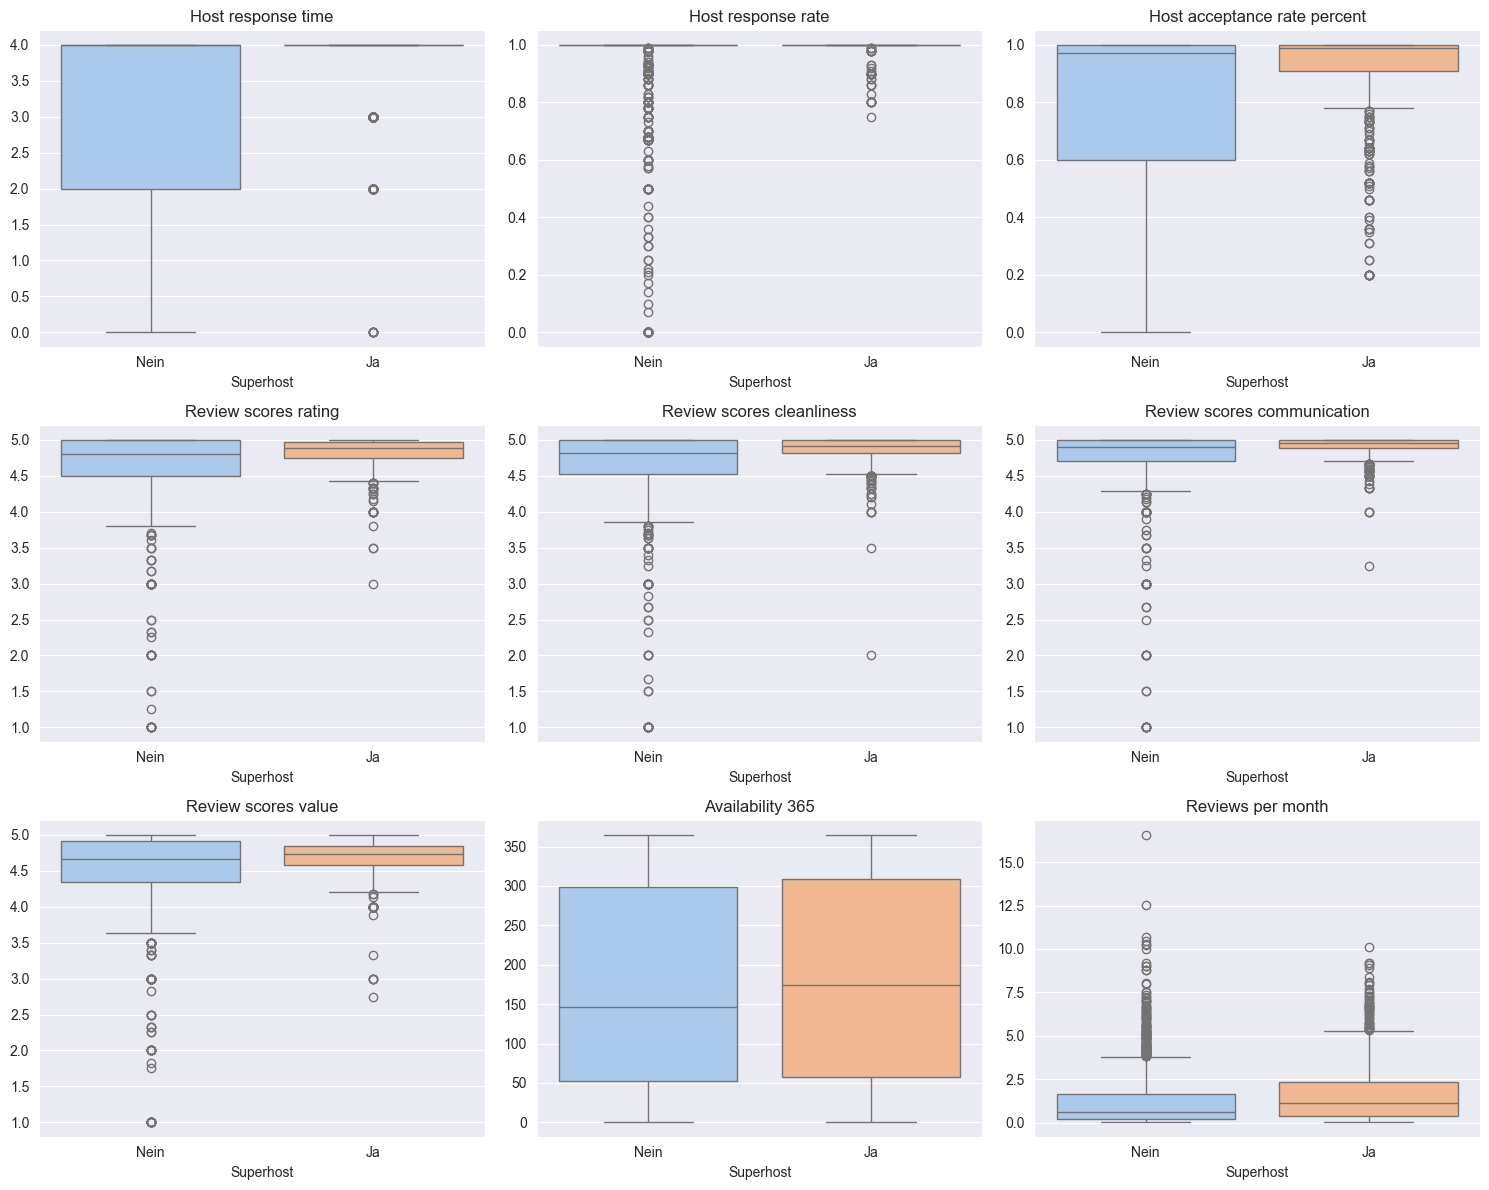

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    'host_response_time', 'host_response_rate', 'host_acceptance_rate_percent',
    'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
    'review_scores_value', 'availability_365', 'reviews_per_month'
]

# Plot-Layout automatisch berechnen
n_cols = 3
n_rows = -(-len(features) // n_cols)  # Aufrunden

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(
    x='host_is_superhost',
    y=feature,
    data=listings_df,
    hue='host_is_superhost',
    palette='pastel',
    legend=False
)

    plt.title(feature.replace('_', ' ').capitalize())
    plt.xlabel("Superhost")
    plt.ylabel("")  # optional für kompaktere Darstellung
    plt.xticks([0, 1], ['Nein', 'Ja'])

plt.tight_layout()
plt.show()


Der deutlichste Unterschied zeigt sich bei der Antwortrate der Gastgeber: Superhosts erreichen nahezu perfekte Werte (nahe 1.0), während Nicht-Superhosts hier stärker streuen und deutlich öfter unterdurchschnittliche Werte aufweisen. Auch bei der Annahmequote ist das Bild eindeutig – Superhosts akzeptieren Buchungsanfragen wesentlich häufiger und zuverlässiger.

Ein weiterer auffälliger Unterschied besteht bei der Antwortzeit: Superhosts antworten im Mittel erheblich schneller. Die Verteilung ist hier deutlich kompakter und auf die besten Antwortkategorien fokussiert, während Nicht-Superhosts oft verzögert oder unregelmässig reagieren.

Bei den Bewertungskriterien – insbesondere Cleanliness, Communication, Rating und Value – schneiden Superhosts nicht nur im Mittel besser ab, sondern zeigen auch eine engere Streuung. Das spricht für ein konstant hohes Qualitätsniveau, das von Gästen entsprechend honoriert wird.

Auch bei der Verfügbarkeit im Jahresverlauf zeigt sich ein Trend: Superhosts bieten ihre Unterkünfte durchschnittlich an mehr Tagen pro Jahr an – ein Indikator für professionelleres Hosting mit höherem Buchungsinteresse. In der Variable reviews_per_month wird dieser Unterschied besonders deutlich: Superhosts erhalten signifikant häufiger Feedback, was auf eine regelmässigere Nutzung und eine höhere Buchungsdichte schliessen lässt.

Fazit und strategische Überlegungen:
- Antwortverhalten systematisch verbessern: InvestZurich AG sollte durch automatisierte Nachrichtenvorlagen und definierte Reaktionszeiten ein schnelleres und verlässlicheres Antwortverhalten sicherstellen.
- Buchungsprozess vereinfachen: Die Aktivierung der Sofortbuchung, wo möglich, kann die Conversion-Rate steigern und das Vertrauen bei Gästen erhöhen.
- Servicequalität messbar sichern: Die kontinuierliche Überwachung von Gästebewertungen (v.a. Sauberkeit, Kommunikation, Preis-Leistung) sollte als Steuerungsgrösse in den Betrieb integriert werden.
- Verfügbarkeit optimieren: Höhere Jahresverfügbarkeit kann die Auslastung deutlich steigern – hier lohnt sich eine Analyse der Saisonalität und Anpassung der Kalenderfreigabe.
- Aktivität fördern: Objekte, die regelmässig Buchungen und Bewertungen generieren, erhöhen die Wahrscheinlichkeit, den Superhost-Status zu erreichen – aktives Nachfrage- und Bewertungsmanagement zahlt sich aus.

Diese Analyse unterstreicht, dass der Superhost-Status auf konsistenter Leistung in mehreren operativen Dimensionen basiert – eine klare Chance für InvestZurich AG, durch gezielte Massnahmen datenbasiert zu optimieren.

### Klassifikationsmodell zur Vorhersage des Superhost-Status

Im folgenden Abschnitt wird ein Klassifikationsmodell aufgebaut, das vorhersagen soll, ob ein Gastgeber den Superhost-Status erreicht. Dafür wird ein Random Forest Classifier verwendet.

Zunächst werden die Daten in Trainings- und Testmengen unterteilt, um die Modellleistung realistisch evaluieren zu können. Nach dem Training des Modells erfolgt eine Klassifikation auf Basis der Testdaten. Die Modellgüte wird anhand klassischer Metriken wie Precision, Recall und F1-Score ausgewertet.

Darüber hinaus liefert das Modell Einblick in die Feature Importance – also die relative Bedeutung einzelner Merkmale für die Entscheidungsfindung des Modells. Diese Information ist besonders wertvoll, um zu verstehen, welche Variablen am stärksten zur Unterscheidung von Superhosts und Nicht-Superhosts beitragen. Die wichtigsten Merkmale werden abschliessend in einem Balkendiagramm visualisiert.


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       252
           1       0.90      0.71      0.79       131

    accuracy                           0.87       383
   macro avg       0.88      0.84      0.85       383
weighted avg       0.88      0.87      0.87       383



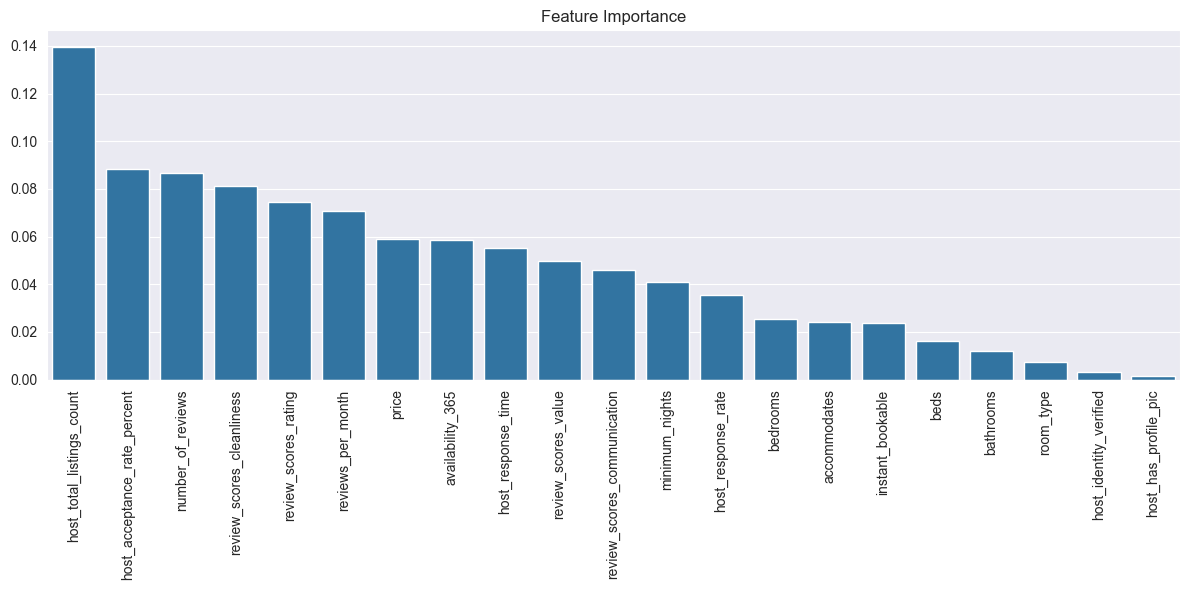

In [28]:
X = listings_df.drop('host_is_superhost', axis=1)
y = listings_df['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

def plot_feature_importance(importance, names):
    plt.figure(figsize=(12, 6))
    indices = np.argsort(importance)[::-1]
    plt.title("Feature Importance")
    sns.barplot(x=np.array(names)[indices], y=importance[indices])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model.feature_importances_, X.columns)

### Bedeutende Einflussfaktoren:

1. **`host_total_listings_count`**
      Hosts mit mehreren Objekten weisen häufiger den Superhost-Status auf. Dies ist weniger ein Hinweis darauf, dass die Anzahl der vermieteten Wohnungen selbst entscheidend ist, sondern vielmehr darauf, dass diese Hosts Airbnb gewerblich oder zumindest professioneller betreiben. Dadurch sind sie tendenziell besser organisiert und schneiden in anderen relevanten Faktoren wie Reaktionszeit, Buchungsannahme und Gästekommunikation besser ab. Die Korrelation könnte zudem dadurch beeinflusst sein, dass erfahrene Gastgeber sich proaktiver um den Superhost-Status bemühen oder besser mit den Anforderungen der Plattform vertraut sind.

2. **`host_response_time`** und **`host_acceptance_rate_percent`**
   Eine schnelle Reaktion auf Anfragen und eine hohe Annahmequote gelten als zentrale Anforderungen, da sie Verlässlichkeit signalisieren.

3. **`reviews_per_month`** und **`review_scores_cleanliness`**
   Regelmässige und qualitativ hochwertige Bewertungen, insbesondere im Bereich Sauberkeit, sprechen für ein hohes Serviceniveau.

### Kritische Einordnung:

- Merkmale wie **`host_identity_verified`** oder **`host_has_profile_pic`** tragen im Modell kaum zur Vorhersagekraft bei. Dies kann durch geringe Varianz in diesen Spalten erklärt werden oder darauf hinweisen, dass sie für Gäste keine ausschlaggebende Rolle spielen.

- Die Ausstattung der Unterkunft (z. B. **`beds`**, **`bathrooms`**, **`room_type`**) ist im Zusammenhang mit dem Superhost-Status weniger relevant, was plausibel erscheint – dieser Status bewertet vorrangig das Verhalten des Hosts.

- Der Einfluss von **`price`** ist ebenfalls gering. Daraus lässt sich schliessen, dass Preisgestaltung allein nicht entscheidend ist – wichtiger ist das gebotene Preis-Leistungs-Verhältnis.

### Fazit:
Die Analyse bestätigt: Der Superhost-Status hängt weniger von der Ausstattung und dem Preis ab, sondern primär von Engagement, Zuverlässigkeit und Kundenzufriedenheit. Für InvestZurich AG bedeutet dies: operative Exzellenz, transparente Kommunikation und kontinuierlich gute Gästebewertungen sind die wesentlichen Stellschrauben zur Erreichung des Superhost-Status.

### Modellvergleich: Random Forest vs. Logistische Regression

Zur Validierung der Modellgüte und zur Einordnung der Ergebnisse wird das Random-Forest-Modell mit einer Logistischen Regression verglichen – einem einfacheren, gut interpretierbaren Klassifikator. Beide Modelle werden mittels 5-facher Cross-Validation bewertet, zusätzlich erfolgt ein Vergleich der ROC-Kurven. Dies ermöglicht eine differenzierte Beurteilung der Trennschärfe und Stabilität beider Modelle.


Logistische Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       252
           1       0.64      0.48      0.55       131

    accuracy                           0.73       383
   macro avg       0.70      0.67      0.68       383
weighted avg       0.72      0.73      0.72       383

Random Forest - durchschnittliche CV-Accuracy: 0.8509152051180402
Logistische Regression - durchschnittliche CV-Accuracy: 0.7144300302106544


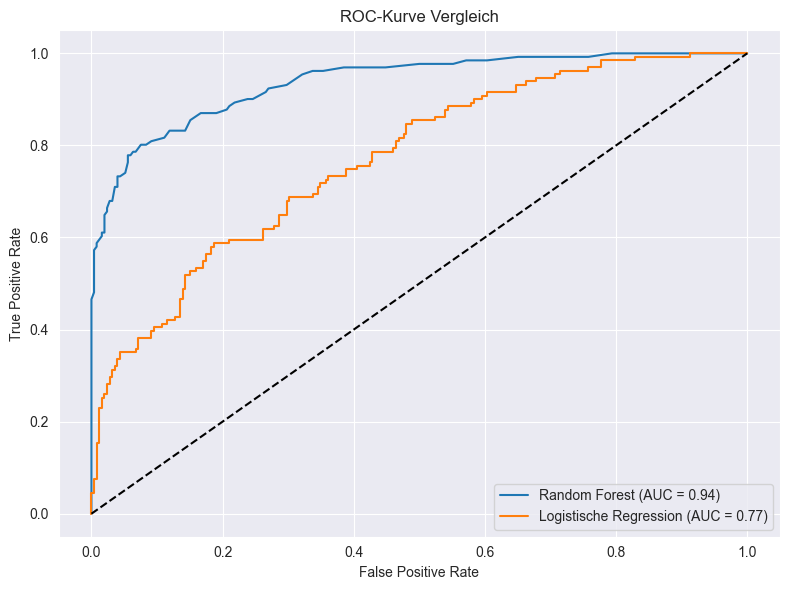

In [29]:
log_model = LogisticRegression(max_iter=1000000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistische Regression - Classification Report:")
print(classification_report(y_test, y_pred_log))

rf_cv_scores = cross_val_score(model, X, y, cv=5)
print("Random Forest - durchschnittliche CV-Accuracy:", rf_cv_scores.mean())

log_cv_scores = cross_val_score(log_model, X, y, cv=5)
print("Logistische Regression - durchschnittliche CV-Accuracy:", log_cv_scores.mean())


probs_rf = model.predict_proba(X_test)[:, 1]
probs_log = log_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
fpr_log, tpr_log, _ = roc_curve(y_test, probs_log)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, probs_rf)))
plt.plot(fpr_log, tpr_log, label='Logistische Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, probs_log)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve Vergleich')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Modellvergleich und Auswahl

Die Gegenüberstellung der beiden Klassifikatoren zeigt einen deutlichen Leistungsunterschied: Der Random Forest erzielt eine AUC von 0.94, während die Logistische Regression bei 0.77 liegt. Auch in der ROC-Kurve wird dieser Unterschied visuell deutlich – der Random Forest verläuft näher an der idealen oberen linken Ecke und weist somit eine höhere Trennschärfe auf.

Die Cross-Validation-Ergebnisse bestätigen dieses Bild: Der Random Forest erreicht im Mittel eine höhere Genauigkeit, zeigt sich gleichzeitig stabil und robust gegenüber unterschiedlichen Trainings-/Test-Splits. Die Logistische Regression liefert akzeptable, aber deutlich schwächere Ergebnisse.

Fazit und Modellwahl:
- Der Random Forest ist dem linearen Modell sowohl bei der Gesamtgüte (AUC) als auch bei der generalisierbaren Genauigkeit (CV-Score) klar überlegen.
- Aufgrund seiner nichtlinearen Struktur kann der Random Forest auch komplexe Zusammenhänge zwischen den Merkmalen besser abbilden – was bei einem vielseitigen Merkmalssatz wie in diesem Fall entscheidend ist.

Für die finale Modellierung und die Ableitung strategischer Empfehlungen wird daher auf den Random Forest als Hauptmodell gesetzt.

## Gesamtfazit und Handlungsempfehlung

Die umfassende Analyse hat gezeigt, dass der Superhost-Status auf Airbnb das Ergebnis eines konsistenten Zusammenspiels aus Gastgeberverhalten, Servicequalität und operativer Professionalität ist. Superhosts unterscheiden sich von anderen Anbietern nicht nur punktuell, sondern durch ein deutlich erkennbares Gesamtprofil: Sie antworten schneller, akzeptieren mehr Anfragen, erhalten bessere Bewertungen und sind insgesamt aktiver und präsenter auf der Plattform.

Die Klassifikationsmodelle – insbesondere der Random Forest – haben diese Zusammenhänge zuverlässig identifiziert und erlauben eine datenbasierte Einschätzung, welche Merkmale für den Superhost-Status entscheidend sind. Dabei zeigen sich sowohl buchungsbezogene Kennzahlen (wie Anzahl Bewertungen, Verfügbarkeit, Buchungsrate) als auch qualitative Aspekte (wie Sauberkeit, Kommunikation, Preis-Leistungs-Verhältnis) als besonders wichtig.

Die Erkenntnisse liefern InvestZurich AG eine klare strategische Richtung:
### Handlungsempfehlung
- Operative Exzellenz sichern: Antwortzeit, Annahmequote und Bewertungsqualität aktiv steuern – z. B. durch klare Prozesse, automatisierte Kommunikation und Schulungen für Gastgeber oder Verwaltungspartner.
- Sichtbarkeit & Aktivität erhöhen: Hohe Objektverfügbarkeit und Sofortbuchung ermöglichen mehr Buchungen und damit mehr Bewertungen – ein zentraler Treiber für den Superhost-Status.
- Monitoring etablieren: Die in dieser Analyse identifizierten KPIs sollten als Teil eines internen Dashboards regelmässig überwacht werden, um gezielt nachzusteuern.
- Zielgerichtet wachsen: Die Ergebnisse bestätigen, dass professionell betriebene, mehrfach gelistete Objekte systematisch erfolgreicher sind. Skalierung sollte jedoch mit gleichbleibender Servicequalität einhergehen.

Insgesamt zeigen die Ergebnisse: Der Superhost-Status ist keine Frage des Zufalls, sondern das Ergebnis eines strukturierten, qualitätsbewussten Managements.